* band pass filter for theta, alpha, beta, and gamma -> single epoch
* compute lcmv
* epochs in source space
* envelope on single epoch (envelope = abs(hilbert))
* average envelopes

In [2]:
import mne
import os
import re
import numpy as np

os.environ['MNE_3D_OPTION_ANTIALIAS']='false' # to make visualization work

current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils import check_paths

import imageio.v3 as iio

import seaborn as sns

In [ ]:
# # create mri dirs in all subs
# #! DON'T LAUNCH ANY MORE

# subs_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
# subs_dir = os.listdir(subs_path)

# for sub_dir in subs_dir:
#     if 'sub' in sub_dir:
#         path = os.path.join(subs_path, sub_dir, 'mri')
#         os.mkdir(path)


In [ ]:
# ONE CELL THAT RULES THEM ALL

# directories to work with
subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'
fsaverage_src_path = os.path.join(mris_dir, 'fsaverage', 'bem', 'fsaverage-ico-5-src.fif')

# dirs to test SR on single subject
subject = 'sub2'
subject_dir = os.path.join(subjects_dir, subject)
# mri_path = os.path.join(mris_dir, subject)
epochs_dir = os.path.join(subject_dir, 'epochs')
epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')

# read epochs and trans files
epochs = mne.read_epochs(epochs_path).pick_types(meg='grad')
info = epochs.info
trans = mne.read_trans(trans_path)

# set frequency bands
epochs_theta = epochs.copy().filter(4., 8.).apply_hilbert(envelope=True)
evoked_theta = epochs_theta.average()

# create source space
src = mne.setup_source_space(
    subject, spacing='oct6', add_dist='patch',
    subjects_dir=mris_dir)
print(src)

# create BEM model
model = mne.make_bem_model(subject=subject, ico=4, #? ico downsampling
                           conductivity=[0.3], # for single layer - suitable for MEG data
                           subjects_dir=mris_dir)
bem = mne.make_bem_solution(model)

# compute the leadfield matrix / forward operator
fwd = mne.make_forward_solution(info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=None,
                                verbose=True)
print(fwd)

# compute data covariance
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=1.5,
                                  method='empirical')
data_cov.plot(epochs.info)

# compute noise covariance from empty room
empty_room_path = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\empty_room\\empty_room_tsss.fif'
empty_room_file =  mne.io.read_raw_fif(empty_room_path, preload=True)
empty_room_file = empty_room_file.resample(200)


empty_room_filt = empty_room_file.copy()\
    .filter(l_freq=.5, h_freq=90)\
    .notch_filter(50) # filter data

noise_cov = mne.compute_raw_covariance(
    empty_room_filt, tmin=0, tmax=None)
noise_cov.plot(epochs.info)

# compute spatial LCMV filter
# in case empty room is used for noise covariance
filters = mne.beamformer.make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank='info', reduce_rank=True)
# reg=0.05 loading the diagonal of the covariance matrix with 5% of the sensor power

# apply spatial LCMV filter to evoked data
stc = mne.beamformer.apply_lcmv(evoked_theta, filters)

In [ ]:
# LCMV beamformes on theta epochs and then averaging
#! Issues with visualization (but the computations should be correct)
stc_epochs_theta = mne.beamformer.apply_lcmv_epochs(epochs_theta, filters)
stc_epochs_theta_averaged = sum(stc_epochs_theta) / len(stc_epochs_theta)

stc_epochs_theta_averaged_viz = stc_epochs_theta_averaged.copy()
stc_epochs_theta_averaged_viz.data = stc_epochs_theta_averaged_viz.data / 1000

In [ ]:
# HITS - MISS theta
stc_hits = mne.beamformer.apply_lcmv(epochs['hits'].pick_types(meg='grad').filter(4., 8.).apply_hilbert(envelope=True).average(), filters) # dipoles x time for condition 1
stc_miss = mne.beamformer.apply_lcmv(epochs['miss'].pick_types(meg='grad').filter(4., 8.).apply_hilbert(envelope=True).average(), filters) # dipoles x time for condition 2
stc_diff = stc_hits - stc_miss

In [20]:
#! ONLY for visualization of source estimates ALL and HITS-MISS in theta
stc_viz = stc.copy()
stc_diff_viz = stc_diff.copy()
stc_viz.data = stc_viz.data / 1000
stc_diff_viz.data = stc_diff_viz.data / 1000

In [30]:
# visualize source estimates ALL
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

fig = stc_viz.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)

In [ ]:
# visualize source estimates HITS-MISS
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

fig = stc_diff_viz.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)


In [33]:
#! ONLY for visualization of source estimates ALL
evoked_epochs = epochs.apply_hilbert(envelope=True).average()
stc_full = mne.beamformer.apply_lcmv(evoked_epochs, filters)
stc_full_viz = stc_full.copy()
stc_full_viz.data = stc_full_viz.data / 1000

In [37]:
# visualize source estimates full spectrum
lims = [0.3, 0.45, 0.6]
kwargs = dict(src=src, subject=subject, subjects_dir=mris_dir,
              initial_time=None, verbose=True)

fig = stc_full_viz.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)

Using control points [ 78166.79121536  94321.61060715 174288.53999656]


**PIPELINE STOPS HERE**

In [ ]:
# # fetch and update fsaverage
# #! DON'T LAUNCH ANY MORE
# fs_ave = mne.datasets.fetch_fsaverage(subjects_dir=mris_dir)

In [32]:
# # directories to work with
# #! LAUNCH ONLY FOR GROUP ANALYSIS
# subjects_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\subjects'
# mris_dir = 'D:\\Ekaterina_Voevodina\\memory_formation\\data\\mri'

# for subject in os.listdir(subjects_dir):
#     subject_path = os.path.join(subjects_dir, subject)
#     # mri_path = os.path.join(mris_dir, subject)
#     trans_path = os.path.join(mris_dir, subject, f'{subject}_trans')
#     epochs_dir = os.path.join(subject_path, 'epochs')
#     epochs_path = os.path.join(epochs_dir, os.listdir(epochs_dir)[0])
#     # epochs = mne.read_epochs(epochs_path)
#     # trans = mne.read_trans(trans_path)


In [ ]:
# # visualize evoked
# #! DON'T ADD TO THE FINAL SCRIPT

# evoked_theta.copy().crop(-0.5, 1.5).plot_joint()
# evoked_alpha.copy().crop(-0.5, 1.5).plot_joint()
# evoked_beta.copy().crop(-0.5, 1.5).plot_joint()
# evoked_gamma.copy().crop(-0.5, 1.5).plot_joint()

In [ ]:
# # visualize BEM surfaces
# #! DON'T ADD TO THE FINAL SCRIPT

# plot_bem_kwargs = dict(
#     subject=subject, subjects_dir=mris_dir,
#     brain_surfaces='white', orientation='coronal')

# mne.viz.plot_bem(src=src, **plot_bem_kwargs)


In [11]:
# # visualization of sources in 3d
# #! DON'T ADD TO THE FINAL SCRIPT

# fig = mne.viz.plot_alignment(subject=subject, subjects_dir=mris_dir,
#                              surfaces='white', coord_frame='mri',
#                              src=src)
# mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
#                     distance=0.30, focalpoint=(-0.03, -0.01, 0.03))


In [ ]:
# # check number of vertices
# #! DON'T ADD TO THE FINAL SCRIPT

# print(f'Before: {src}')
# print(f'After:  {fwd["src"]}')

# # numpy array containing gain matrix
# leadfield = fwd['sol']['data']
# print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# # numpy array containing the forward operator corresponding to the source space
# #! DON'T ADD TO THE FINAL SCRIPT

# fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
#                                          use_cps=True)
# leadfield = fwd_fixed['sol']['data']
# print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
# # save forward solution
# #? How to set the path?

# fwd_save = mne.write_forward_solution('forward_solution.fif', fwd_fixed, overwrite=False) #?

# # mne.read_forward_solution(fname, include=(), exclude=(), verbose=None) to read the fwd solution file

In [ ]:
# #! DON'T ADD TO THE FINAL SCRIPT

# mne.viz.plot_alignment(info, trans, subject=subject, dig=True,
#                        meg=['helmet', 'sensors'], subjects_dir=mris_dir,
#                        surfaces='head-dense')

In [ ]:
# # regularization of noise covariance matrix
# #noise_cov_reg = mne.cov.regularize(noise_cov, empty_room_filt.info, mag=1e6, grad=1e6)
# #noise_cov_reg.plot(empty_room_filt.info)

# noise_numpy_cov = noise_cov.data
# noise_cov2 = noise_cov.copy()
# u,s,v = np.linalg.svd(noise_cov_numpy)
# print(s.shape)
# regMatrix = np.eye(s.shape[0])*1e0
# noise_numpy_cov += regMatrix
# noise_cov2  = mne.Covariance(noise_numpy_cov, epochs.info['ch_names'],epochs.info['bads'],epochs.info['projs'], 0)


**PLAYING WITH THE DATA**

In [29]:
df = stc[0].to_data_frame().drop(['subject', 'time'], axis=1)

In [45]:
df.iloc[0:21, :]

,LH_19,LH_225,LH_336,LH_350,LH_423,LH_510,LH_518,LH_542,LH_570,LH_578,...,RH_151007,RH_151057,RH_151113,RH_151157,RH_151196,RH_151202,RH_151232,RH_151265,RH_151276,RH_151355
0,-195.561923,-361.962309,-691.116709,673.834566,-457.593337,-345.667738,-547.565142,60.056038,523.102593,-119.538079,...,-369.608528,197.952052,477.072761,527.024971,-588.331155,-556.617999,543.264092,556.238492,327.954707,-539.222738
1,87.499494,-382.796178,-474.483554,482.961294,-109.881314,-365.158505,-403.185023,315.012869,490.644562,202.364308,...,-346.500209,-47.472710,484.620153,195.387503,-490.314297,-468.482183,421.840460,423.409978,338.339263,-298.094425
2,127.693710,-436.154462,-560.857194,581.733569,-48.793345,-417.940266,-451.716272,433.768011,591.072228,315.299172,...,-409.106818,-88.941642,628.677903,206.382005,-617.082643,-599.972384,544.650677,543.455357,452.944518,-372.499119
3,215.162650,-505.835923,-584.842151,616.477530,37.016856,-490.696303,-487.917401,573.609789,675.450555,440.506464,...,-462.217266,-186.003088,738.024985,164.144263,-683.733617,-665.184835,600.227953,598.343492,521.703682,-370.319628
4,265.436842,-570.519638,-670.863899,716.238483,106.547082,-557.725690,-545.533357,712.278166,788.320718,564.721401,...,-532.180214,-250.071003,899.588758,175.789219,-816.314906,-800.082207,728.177005,725.029912,638.685136,-442.868645
5,303.349744,-619.037300,-727.453075,781.424368,154.070098,-609.011015,-588.237423,812.024256,868.252263,647.879803,...,-579.861506,-300.116484,1008.000989,179.905792,-901.990013,-887.773750,811.572985,807.580436,718.198649,-486.727443
6,350.520051,-682.212492,-815.570356,883.786695,225.145978,-676.053909,-647.347761,953.818412,983.269851,771.684758,...,-649.674641,-367.591362,1175.725788,196.462433,-1038.099122,-1026.463964,945.216984,940.360554,838.396692,-564.443694
7,364.685934,-715.685167,-885.992923,962.394209,260.306893,-711.950328,-687.812123,1035.123995,1057.927309,838.346323,...,-691.973398,-393.813000,1283.324529,219.481944,-1133.020246,-1126.421403,1043.279227,1036.921286,926.095227,-631.093079
8,401.327681,-768.844982,-972.900645,1063.035198,327.139161,-769.633188,-742.036664,1166.443505,1165.152796,951.388642,...,-755.011673,-453.255119,1444.180940,241.213363,-1265.095602,-1262.496485,1176.365017,1169.021509,1044.487032,-712.941205
9,403.018142,-793.873726,-1051.422253,1149.876497,357.656326,-797.027691,-781.014006,1239.655573,1237.723580,1011.149769,...,-794.747208,-467.620424,1553.733568,274.479734,-1366.845517,-1371.112676,1284.465478,1275.213987,1138.478336,-793.249665


<AxesSubplot:>

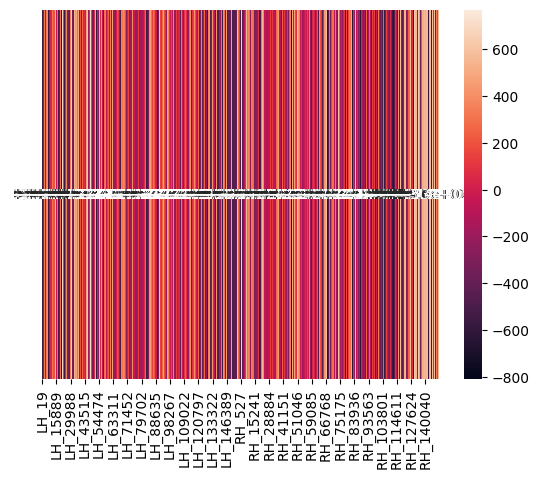

In [48]:
sns.heatmap(df.iloc[[0]], annot=True)

In [ ]:
import numpy as np

stc_data = np.array([
    stc_.data
    for stc_ in stc
])

In [71]:
stc_data.shape

(210, 8192, 1100)

In [45]:
filedir = os.path.join(subject_dir, 'movie', 'theta')
check_paths(filedir)

In [17]:
# visualize the sources and save the movie
# launch only for GROUP analysis

filepath = os.path.join(filedir, 'sources_all_post.mp4')

%matplotlib inline
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)
fig.save_movie(filename=filepath, time_dilation=4.0, tmin=-1.0, tmax=2.0)


Using pyvistaqt 3d backend.



In [46]:
filepath = os.path.join(filedir, 'sources_all_post.mp4')
fig = stc.plot(hemi='both', views=['dorsal', 'ventral'], clim=dict(kind='value', pos_lims=lims), **kwargs)

**STOPPED HERE**

In [27]:
import numpy as np
np.min(stc_diff.data[1,:])
lims

[0.3, 0.45, 0.6]

In [18]:
# Create a SourceMorph from one subject to another
stc_fs = mne.compute_source_morph(src, subject_from='sub2', subject_to='fsaverage', subjects_dir=mris_dir).apply(stc)
stc_fs.plot()

ValueError: vertices do not match between morph (4098) and stc (4094) for left hemisphere:
[    19    225    336 ... 158318 158352 158370]
[    19    225    336 ... 158318 158352 158370]
Perhaps src_to=fwd["src"] needs to be passed when calling compute_source_morph. Vertices were likely excluded during forward computation.